# Variational Auto-Encoder


## Import Libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load and Preprocess Data

In [2]:
def load_and_preprocess_data():
    (x_train, _), (x_test, _) = fashion_mnist.load_data()
    x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)).astype('float32') / 255.0
    x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)).astype('float32') / 255.0
    return x_train, x_test

x_train, x_test = load_and_preprocess_data()

## Visualization

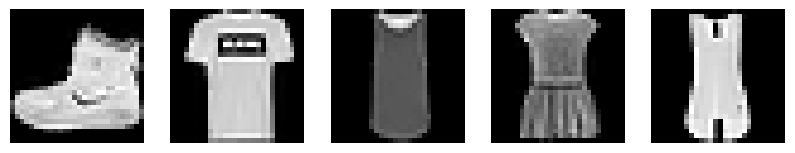

In [3]:
def display_sample_images(x_train, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

display_sample_images(x_train, 5)

## Define Latent Space as a Distribution

In [4]:
def create_encoder(latent_dim):
    encoder_inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    return models.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

latent_dim = 64  
encoder = create_encoder(latent_dim)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                            

## Define Reparameterization

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def create_variational_encoder(latent_dim):
    encoder_inputs = layers.Input(shape=(28, 28, 1))
    z_mean, z_log_var = create_encoder(latent_dim)(encoder_inputs)
    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return models.Model(encoder_inputs, [z_mean, z_log_var, z], name='variational_encoder')

variational_encoder = create_variational_encoder(latent_dim)
variational_encoder.summary()


Model: "variational_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 64),         436864      ['input_2[0][0]']                
                                 (None, 64)]                                                      
                                                                                                  
 z (Lambda)                     (None, 64)           0           ['encoder[0][0]',                
                                                                  'encoder[0][1]']                
                                                                                

## Define the Decoder

In [6]:
def create_decoder(latent_dim):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D()(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    return models.Model(decoder_inputs, decoder_outputs, name='decoder')

decoder = create_decoder(latent_dim)
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_2 (Dense)             (None, 3136)              203840    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 32)       1846

## Create the VAE Class

In [7]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)  
        return reconstructed

vae = VAE(variational_encoder, decoder)
vae.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy)

## Data Augmentation and Callbacks

In [22]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)  
        return reconstructed

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'encoder': self.encoder,
            'decoder': self.decoder
        })
        return config

vae = VAE(variational_encoder, decoder)
vae.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy)

checkpoint = ModelCheckpoint('vae_model', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             save_format="tf")



## Train the VAE

In [19]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
tf.config.set_visible_devices(tf.config.get_visible_devices('GPU')[0], 'GPU')

# Verify that the GPU is being used
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [23]:
vae.fit(data_gen.flow(x_train, x_train, batch_size=64), 
        epochs=50, 
        validation_data=(x_test, x_test), 
        callbacks=[checkpoint])

Epoch 1/50
937/938 [============================>.] - ETA: 0s - loss: 0.4072
Epoch 1: val_loss improved from inf to 0.40620, saving model to vae_model


INFO:tensorflow:Assets written to: vae_model\assets


INFO:tensorflow:Assets written to: vae_model\assets


938/938 [==============================] - 16s 17ms/step - loss: 0.4072 - val_loss: 0.4062
Epoch 2/50
934/938 [============================>.] - ETA: 0s - loss: 0.4057
Epoch 2: val_loss did not improve from 0.40620
938/938 [==============================] - 14s 15ms/step - loss: 0.4057 - val_loss: 0.4091
Epoch 3/50
936/938 [============================>.] - ETA: 0s - loss: 0.4054
Epoch 3: val_loss did not improve from 0.40620
938/938 [==============================] - 13s 14ms/step - loss: 0.4054 - val_loss: 0.4072
Epoch 4/50
937/938 [============================>.] - ETA: 0s - loss: 0.4046
Epoch 4: val_loss did not improve from 0.40620
938/938 [==============================] - 14s 14ms/step - loss: 0.4046 - val_loss: 0.4063
Epoch 5/50
935/938 [============================>.] - ETA: 0s - loss: 0.4041
Epoch 5: val_loss did not improve from 0.40620
938/938 [==============================] - 13s 14ms/step - loss: 0.4040 - val_loss: 0.4083
Epoch 6/50
936/938 [============================>

INFO:tensorflow:Assets written to: vae_model\assets


INFO:tensorflow:Assets written to: vae_model\assets


938/938 [==============================] - 15s 16ms/step - loss: 0.4031 - val_loss: 0.4036
Epoch 8/50
934/938 [============================>.] - ETA: 0s - loss: 0.4030
Epoch 8: val_loss did not improve from 0.40357
938/938 [==============================] - 14s 15ms/step - loss: 0.4029 - val_loss: 0.4080
Epoch 9/50
935/938 [============================>.] - ETA: 0s - loss: 0.4026
Epoch 9: val_loss did not improve from 0.40357
938/938 [==============================] - 13s 14ms/step - loss: 0.4026 - val_loss: 0.4052
Epoch 10/50
938/938 [==============================] - ETA: 0s - loss: 0.4022
Epoch 10: val_loss did not improve from 0.40357
938/938 [==============================] - 14s 15ms/step - loss: 0.4022 - val_loss: 0.4107
Epoch 11/50
935/938 [============================>.] - ETA: 0s - loss: 0.4022
Epoch 11: val_loss improved from 0.40357 to 0.40326, saving model to vae_model


INFO:tensorflow:Assets written to: vae_model\assets


INFO:tensorflow:Assets written to: vae_model\assets


938/938 [==============================] - 16s 17ms/step - loss: 0.4023 - val_loss: 0.4033
Epoch 12/50
935/938 [============================>.] - ETA: 0s - loss: 0.4019
Epoch 12: val_loss did not improve from 0.40326
938/938 [==============================] - 15s 16ms/step - loss: 0.4019 - val_loss: 0.4060
Epoch 13/50
935/938 [============================>.] - ETA: 0s - loss: 0.4017
Epoch 13: val_loss did not improve from 0.40326
938/938 [==============================] - 17s 18ms/step - loss: 0.4017 - val_loss: 0.4080
Epoch 14/50
936/938 [============================>.] - ETA: 0s - loss: 0.4015
Epoch 14: val_loss did not improve from 0.40326
938/938 [==============================] - 16s 17ms/step - loss: 0.4014 - val_loss: 0.4068
Epoch 15/50
934/938 [============================>.] - ETA: 0s - loss: 0.4013
Epoch 15: val_loss did not improve from 0.40326
938/938 [==============================] - 18s 19ms/step - loss: 0.4013 - val_loss: 0.4079
Epoch 16/50
936/938 [====================

INFO:tensorflow:Assets written to: vae_model\assets


INFO:tensorflow:Assets written to: vae_model\assets


938/938 [==============================] - 19s 20ms/step - loss: 0.3971 - val_loss: 0.4020
Epoch 47/50
938/938 [==============================] - ETA: 0s - loss: 0.3971
Epoch 47: val_loss did not improve from 0.40196
938/938 [==============================] - 18s 19ms/step - loss: 0.3971 - val_loss: 0.4091
Epoch 48/50
937/938 [============================>.] - ETA: 0s - loss: 0.3967
Epoch 48: val_loss did not improve from 0.40196
938/938 [==============================] - 17s 18ms/step - loss: 0.3967 - val_loss: 0.4070
Epoch 49/50
936/938 [============================>.] - ETA: 0s - loss: 0.3969
Epoch 49: val_loss did not improve from 0.40196
938/938 [==============================] - 16s 17ms/step - loss: 0.3969 - val_loss: 0.4063
Epoch 50/50
937/938 [============================>.] - ETA: 0s - loss: 0.3968
Epoch 50: val_loss did not improve from 0.40196
938/938 [==============================] - 16s 17ms/step - loss: 0.3968 - val_loss: 0.4053


## Inference 
##### The VAE model shows stable and consistent learning over 50 epochs, with both training and validation losses decreasing gradually and staying closely aligned, indicating good generalization without overfitting. The marginal reduction in loss over the last several epochs suggests that the model is nearing convergence. 

##### Overall, the model is performing well and has learned to reconstruct the data effectively.






## Generating New Data

1/1 [==============================] - 0s 259ms/step


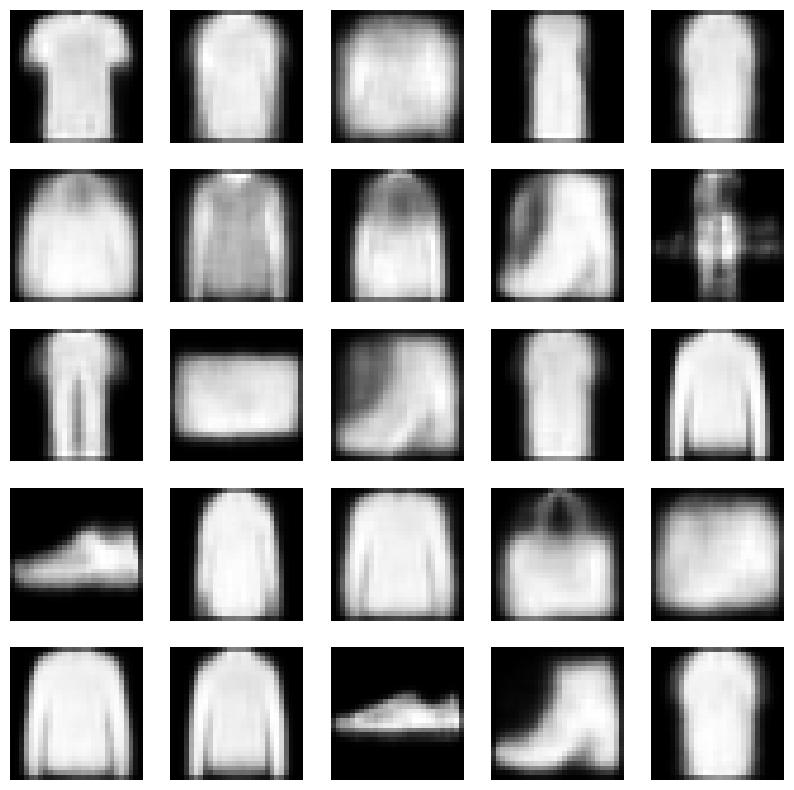

In [24]:
def plot_generated_images(decoder, n=25):
    z_samples = tf.random.normal(shape=(n, latent_dim))  
    generated_images = decoder.predict(z_samples)

    plt.figure(figsize=(10, 10)) 
    for i in range(n):
        plt.subplot(5, 5, i + 1)  
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()

plot_generated_images(decoder)


## Conclusion 
##### The Variational Autoencoder (VAE) model showed stable training behavior over 50 epochs, with the training and validation losses remaining close to each other, indicating no significant overfitting. The final validation loss of approximately 0.4006 suggests that the model has learned to reconstruct the input data.